# Imports

In [23]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [24]:
import torch
import matplotlib.pyplot as plt

In [25]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (15, 5)

In [26]:
import pandas as pd
pd.options.display.max_columns = None

In [27]:
%run ../utils/__init__.py
config_logging(logging.INFO)

# Load model

In [28]:
%run ../models/checkpoint/__init__.py

In [29]:
load_model = load_compiled_model_classification

In [30]:
# kwargs = {
#     'run_name': '0317_180952_vinbig_densenet-121-v2_hint-1_gmax_normD_size200_lr0.0001_sch-roc_auc-p3-f0.1',
#     'debug': True,
#     'task': 'det',
# }

# kwargs = {
#     'run_name': '0317_110119_vinbig_densenet-121-v2_drop0.3_normD_wd0.001_size256_lr0.0001_sch-roc_auc-p3-f0.1',
#     'debug': False,
#     'task': 'cls',
# }

# kwargs = {
#     'run_name': '0318_154252_vinbig_densenet-121-v2_drop0.3_normD_wd0.001_size256_lr0.0001_sch-roc_auc-p2-f0.1',
#     'debug': False,
# }

# kwargs = {
#     'run_name': '0322_212629_vinbig_densenet-121-v2_hint-1_normD_size200_lr0.0001_sch-roc_auc-p3-f0.5_shuffle',
#     'debug': True,
#     'task': 'det',
# }

kwargs = {
    # 'run_name': '0325_222238_vinbig_resnet-scan_normD_lr0.0001_sch-iou-p3-f0.5_best-iou',
    # 'run_name': '0326_131807_vinbig_resnet-scan_seg-only-dis_normD_lr0.0001_sch-iou-p3-f0.5_best-iou',
    'run_name': '0327_004005_vinbig_resnet-scan_seg-only-dis_normD_lr0.0001_sch-iou-p3-f0.5_aug_best-iou',
    'debug': False,
}
load_model = load_compiled_model_detection_seg

In [31]:
compiled_model = load_model(**kwargs)
compiled_model.model.eval()
compiled_model.metadata['model_kwargs']

{'model_name': 'resnet-scan',
 'labels': ['Aortic enlargement',
  'Atelectasis',
  'Calcification',
  'Cardiomegaly',
  'Consolidation',
  'ILD',
  'Infiltration',
  'Lung Opacity',
  'Nodule/Mass',
  'Other lesion',
  'Pleural effusion',
  'Pleural thickening',
  'Pneumothorax',
  'Pulmonary fibrosis'],
 'gpool': 'avg'}

# Load data

In [32]:
%run ../datasets/__init__.py

In [33]:
dataset_kwargs = {
    'dataset_name': 'vinbig',
    'dataset_type': 'test', # train-val
    'max_samples': None,
    'masks': True,
    'image_size': (512, 512),
    'bboxes': True,
    'image_format': 'L',
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

[__main__] INFO(03-29 20:56) Loading vinbig/test cl-dataset, bs=10 imgsize=(512, 512) version=None format=L n_labels=None
[__main__] INFO(03-29 20:56) Loading vinbig/test cl-dataset, bs=10 imgsize=(512, 512) version=None format=L n_labels=None
WARNING(03-29 20:56) Vinbig test-dataset labels are dummy (not real)!!
WARNING(03-29 20:56) Vinbig test-dataset labels are dummy (not real)!!
[__main__] INFO(03-29 20:56) 	Dataset size: 3000
[__main__] INFO(03-29 20:56) 	Dataset size: 3000


3000

# Show some examples

## Plot cxr and masks

In [12]:
idx = 4

item = dataset[idx]
item.image_fname, item.labels, item.image.size(), item.masks.size()

('0007d316f756b3fa0baea2ff514ce945',
 array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]),
 torch.Size([3, 256, 256]),
 torch.Size([14, 256, 256]))

Text(0.5, 1.0, 'Aortic enlargement')

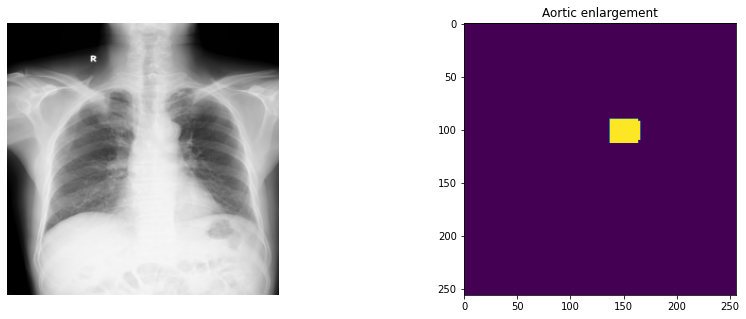

In [13]:
n_rows = 1
n_cols = 2

disease_idx = 0

plt.subplot(n_rows, n_cols, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(n_rows, n_cols, 2)
plt.imshow(item.masks[disease_idx])
plt.title(dataset.labels[disease_idx])

## Plot predictions

### Functions

#### Common utils

In [34]:
from matplotlib.patches import Rectangle

In [35]:
%run ../training/detection/h2bb/thresh_largest_area.py
%run ../utils/shapes.py

In [36]:
%run ../training/detection/h2bb/thresh_multiple.py

In [37]:
N_DISEASES = len(dataset.labels)

In [38]:
def pred_and_label_to_valoration(presence, gt):
    if presence + gt == 2:
        result = 'TP'
    elif presence + gt == 0:
        result = 'TN'
    elif presence == 1:
        result = 'FP'
    else:
        result = 'FN'
    return result

In [39]:
def print_predictions(pred_labels, gt_labels, cls_thresh=0.3):
    print('Predictions: ')
    for score, disease, gt in zip(pred_labels, dataset.labels, gt_labels):
        presence = int(score > cls_thresh)
        result = pred_and_label_to_valoration(presence, gt)
        print(f'\t{disease:<20} = {score:.2f} (pred={presence}) | gt={gt} | value={result}')

In [47]:
def plot_sample(item, preds, heatmaps,
                cls_thresh=0.3, heat_thresh=0.5,
                only=None, only_diseases=None,
               ):
    if only:
        if isinstance(only, str):
            only = (only,)

        n_targets = sum(
            1
            for score, gt in zip(preds, item.labels)
            if pred_and_label_to_valoration(score > cls_thresh, gt) in only
        )

        if n_targets == 0:
            print(f'No predictions with valorations {only}')
            return
    else:
        n_targets = N_DISEASES
    
    n_cols = 3
    n_rows = n_targets

    plt.figure(figsize=(n_cols * 5, n_rows * 5))
    plot_row_idx = 0
    # palette_colors = plt.cm.get_cmap('jet', N_DISEASES)

    bboxes_by_disease_id = defaultdict(list)
    for bbox in item.bboxes:
        bbox_disease_id = bbox[0]
        bboxes_by_disease_id[bbox_disease_id].append(bbox[1:])
    
    plotable_image = tensor_to_range01(item.image).permute(1, 2, 0)
    plotable_image = plotable_image.squeeze()

    for disease_idx in range(len(dataset.labels)):
        if only_diseases is not None and disease_idx not in only_diseases:
            continue

        disease_name = dataset.labels[disease_idx]
        gt = item.labels[disease_idx]
        score = preds[disease_idx]
        pred = score > cls_thresh
        valoration = pred_and_label_to_valoration(pred, gt)
        
        if only is not None and valoration not in only:
            continue
        
        # Plot image with GT bboxes
        plt.subplot(n_rows, n_cols, plot_row_idx + 1)
        plt.title(f'{disease_idx}-{disease_name} (GT={gt})')
        plt.imshow(plotable_image, cmap='gray')
        # plt.axis('off')
        
        for bbox in bboxes_by_disease_id[disease_idx]:
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin
            rect = Rectangle((xmin, ymin), width, height,
                             fill=False, linewidth=2,
                             edgecolor='green')
            ax = plt.gca()
            ax.add_patch(rect)
        
        # Plot heatmap
        plt.subplot(n_rows, n_cols, plot_row_idx + 2)
        heatmap = heatmaps[disease_idx] # shape: height, width
        plt.title(f'score={score:.2f} pred={pred} ({valoration})')
        plt.imshow(heatmap)
        # plt.axis('off')
        plt.colorbar()
        

        # Plot image with pred bboxes
        plt.subplot(n_rows, n_cols, plot_row_idx + 3)
        plt.imshow(plotable_image, cmap='gray')
        title = 'BB from heatmap'
        # plt.axis('off')

        # Use algorithm 1:
#         bb = _h2bb_thresh_largest_area(heatmap, heat_thresh)
#         bbs = [(0, bb)]

        # Use algorithm 2:
        bbs = _h2bb_thresh_multiple(heatmap, heat_thresh) or []
        
        print(bbs)
        
        for score, bb in bbs:
            xmin, ymin, xmax, ymax = bb
            height = ymax - ymin
            width = xmax - xmin
            rect = Rectangle((xmin, ymin), width, height,
                             fill=False, linewidth=2,
                             edgecolor='red')
            ax = plt.gca()
            ax.add_patch(rect)
            
        if len(bbs) == 0:
            print(f'No BB could be extracted for {disease_name}')
        else:
            # Calculate IoU with GT
            gt_bboxes = bboxes_by_disease_id[disease_idx]
            if len(gt_bboxes) > 0:
                best_iou = max(
                    calc_iou(pred_bb, gt_bb)
                    for _, pred_bb in bbs
                    for gt_bb in gt_bboxes
                )
                title += f' IoU={best_iou:.2f}'
            else:
                title += ' (no GT)'
            
        plt.title(title)    
        
        plot_row_idx += n_cols

#### Prediction for hint-based model

In [20]:
%run ../training/classification/grad_cam.py

In [18]:
grad_cam = create_grad_cam(compiled_model.model, device='cuda')
grad_cam

In [19]:
def predict_sample(item):
    images = item.image.unsqueeze(0).cuda()
    
    with torch.no_grad():
        output = compiled_model.model(images)
        pred = output[0].squeeze(0)
        pred = torch.sigmoid(pred).cpu()

    with torch.set_grad_enabled(True):
        images.requires_grad = True
        heatmaps = calculate_attributions_for_labels(
            grad_cam, images, N_DISEASES, relu=True, create_graph=False,
        ).detach().squeeze(0).cpu()

    images.requires_grad = False

    return pred, heatmaps

#### Prediction for det-seg model

In [41]:
def predict_sample(item):
    images = item.image.unsqueeze(0).cuda()
    with torch.no_grad():
        pred_labels, pred_masks = compiled_model.model(images)
        
    pred_labels = torch.sigmoid(pred_labels).squeeze(0).cpu()
    pred_masks = torch.sigmoid(pred_masks).squeeze(0).cpu()

    return pred_labels, pred_masks

### Plot

In [42]:
%run ../training/detection/h2bb/thresh_multiple.py

In [43]:
CLS_THRESH = 0.3
HEATMAP_THRESH = 0.6

[(0.6041752696037292, (200.0, 215.0, 201.0, 216.0)), (0.6026612520217896, (63.0, 295.0, 64.0, 296.0)), (0.6000016331672668, (396.0, 293.0, 397.0, 294.0))]
[(1.0, (56.0, 168.0, 217.0, 333.0)), (0.7846524119377136, (376.0, 280.0, 427.0, 329.0))]
[(0.6307815313339233, (207.0, 202.0, 216.0, 216.0)), (0.6014297008514404, (208.0, 200.0, 209.0, 201.0)), (0.6011887192726135, (208.0, 237.0, 209.0, 238.0))]
[(1.0, (56.0, 108.0, 216.0, 316.0))]


('0aed23e64ebdea798486056b4f174424', tensor([2304, 2880]))

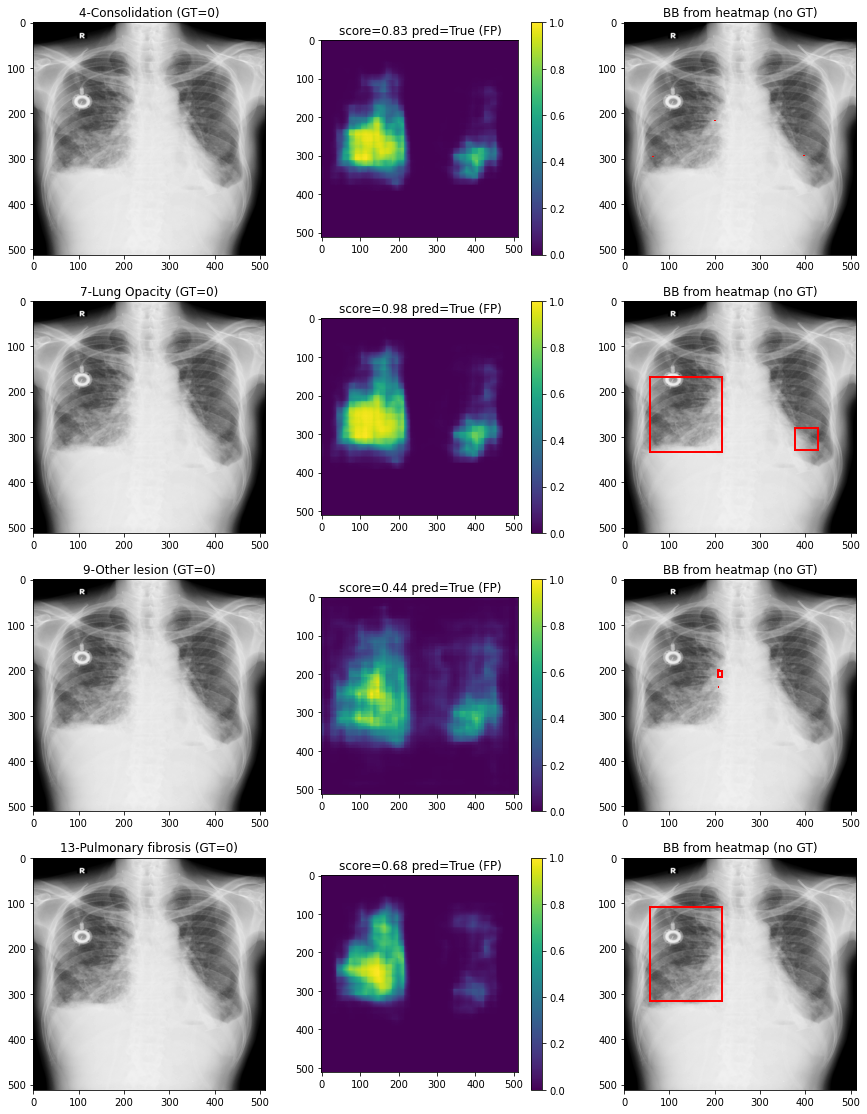

In [54]:
item = dataset[11] # 14, 100 # 11
preds, heatmaps = predict_sample(item)
heatmaps = tensor_to_range01(heatmaps)
# # print_predictions(preds, item.labels, cls_thresh=CLS_THRESH)
plot_sample(item, preds, heatmaps,
            cls_thresh=CLS_THRESH, heat_thresh=HEATMAP_THRESH,
            # only=('TP', 'FN'),
            only=('TP', 'FP'),
            only_diseases=[4, 7, 9, 13],
           )
item.image_fname, item.original_size

In [67]:
list(enumerate(dataset.labels))

[(0, 'Aortic enlargement'),
 (1, 'Atelectasis'),
 (2, 'Calcification'),
 (3, 'Cardiomegaly'),
 (4, 'Consolidation'),
 (5, 'ILD'),
 (6, 'Infiltration'),
 (7, 'Lung Opacity'),
 (8, 'Nodule/Mass'),
 (9, 'Other lesion'),
 (10, 'Pleural effusion'),
 (11, 'Pleural thickening'),
 (12, 'Pneumothorax'),
 (13, 'Pulmonary fibrosis')]

In [65]:
item.image.size()

torch.Size([3, 256, 256])

In [66]:
heatmaps.size()

torch.Size([14, 256, 256])

In [43]:
heatmaps.size()

torch.Size([14, 512, 512])

In [ ]:
bbs = 

In [44]:
a = torch.randn(8, 8)
a

tensor([[-0.2973,  1.9725,  0.6437, -0.6766, -1.7193, -0.2304,  0.5624, -0.9081],
        [ 0.3549,  0.4395,  0.6666,  1.7204,  0.5487, -0.0814,  0.3209,  1.4983],
        [-0.2585,  0.7115, -0.3411,  0.6750,  0.7910, -0.6350, -2.0454, -1.9847],
        [-0.8738,  0.2115,  0.7086, -0.2838, -0.3190, -1.9720,  0.4870,  0.9037],
        [ 0.2291,  1.1360, -0.4319, -0.7916, -0.6022, -0.2751,  1.3125,  0.8985],
        [-1.6268, -0.9679, -2.0074,  1.9122, -0.9503,  0.7090,  1.4506,  1.2927],
        [-1.0913, -0.5544,  2.0518,  1.2130,  0.5321,  2.3895,  0.2686, -0.5881],
        [-0.7736, -1.3994,  0.9188,  1.6680, -1.7312, -1.4086, -1.2255, -0.3614]])

In [46]:
a[3:5, 3:5].max().item()

-0.28379571437835693

In [35]:
b = tensor_to_range01(a)
b

tensor([[[0.8025, 0.8254, 0.6280, 0.4451],
         [0.4162, 0.2401, 0.6904, 1.0000],
         [0.6593, 0.3615, 0.4862, 0.4974],
         [0.2829, 0.6423, 0.3724, 0.0000]],

        [[0.9201, 1.0000, 0.9649, 0.6557],
         [0.5855, 0.4089, 0.7713, 0.4382],
         [0.4198, 0.2977, 0.7866, 0.0000],
         [0.6039, 0.8663, 0.4746, 0.4654]]])

In [36]:
b[0].min(), b[0].max(), b[1].min(), b[1].max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

# DEBUG OTHER STUFF

DELETEME

In [55]:
data_batch = next(iter(dataloader))
# data_batch

In [56]:
# Move inputs to GPU
images = data_batch.image.cuda()
# shape: batch_size, channels=3, height, width

gt_labels = data_batch.labels.cuda()
# shape(multilabel=True): batch_size, n_labels

gt_masks = data_batch.masks.cuda()
# shape: batch_size, n_diseases, height, width

# Enable training
compiled_model.model.train(True)
torch.set_grad_enabled(True)

In [57]:
images.size(), gt_labels.size(), gt_masks.size()

(torch.Size([10, 1, 256, 256]),
 torch.Size([10, 14]),
 torch.Size([10, 14, 256, 256]))

In [58]:
seg_loss_fn = nn.BCEWithLogitsLoss(reduction='none')

In [59]:
# Forward
pred_labels, pred_masks = compiled_model.model(images)
pred_labels.size(), pred_masks.size()

(torch.Size([10, 14]), torch.Size([10, 14, 256, 256]))

In [60]:
seg_loss = seg_loss_fn(pred_masks, gt_masks.float())
seg_loss.size()

torch.Size([10, 14, 256, 256])

In [62]:
seg_loss.requires_grad

True

In [18]:
seg_loss.ndim

4

In [20]:
batch_size, n_diseases = gt_labels.size()
batch_size, n_diseases

(10, 14)

In [24]:
gt_labels[0].sum()

False

In [63]:
zero_labels = torch.zeros(batch_size, n_diseases, device='cuda').long()
zero_labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [29]:
index = torch.tensor([i for i in range(batch_size) if gt_labels[i].sum()]).cuda()
index

tensor([2, 4, 6, 7, 9], device='cuda:0')

In [33]:
seg_loss2 = seg_loss.sum(dim=(-1,-2))
seg_loss2

tensor([[  5998.3638,  10237.2227,  10867.7227,   4678.8926,  10487.3223,
          10286.4629,  10982.4707,  12450.7344,  11783.7529,  12016.9863,
          11905.1113,  14916.5918,  10044.3926,  13527.0273],
        [  7099.9287,  13412.3135,  14153.6094,   5777.3647,  13713.6035,
          13460.4697,  14271.4717,  15696.9199,  15071.4805,  15224.8525,
          15091.5361,  17904.4453,  13147.0996,  16766.4688],
        [  8269.6133,  41469.9844,  41900.2812,   7511.6934,  17865.6445,
          40931.9062,  15678.4668,  12144.6025,  13430.7500,  41452.8320,
          41717.4375,  46812.4180,  41192.2461,  45123.3242],
        [  5908.4268,  10715.4062,  11454.4160,   5211.4688,  11040.9844,
          10767.6484,  11596.9629,  12987.0244,  12405.3281,  12447.4561,
          12428.3691,  15013.9629,  10430.5625,  13881.6504],
        [  7090.7900,   8237.2617,   9173.6758,   4718.4238,   8595.3428,
          25229.8672,   9281.8643,  11199.1221,  10347.9287,  10908.3984,
          10

In [34]:
seg_loss2.index_select(dim=0, index=index1)

tensor([[  8269.6133,  41469.9844,  41900.2812,   7511.6934,  17865.6445,
          40931.9062,  15678.4668,  12144.6025,  13430.7500,  41452.8320,
          41717.4375,  46812.4180,  41192.2461,  45123.3242],
        [  7090.7900,   8237.2617,   9173.6758,   4718.4238,   8595.3428,
          25229.8672,   9281.8643,  11199.1221,  10347.9287,  10908.3984,
          10691.6396,  13791.5498,   7915.4819,  16219.5439],
        [  5066.4917,  12809.9824,  13492.4521,   4966.4761,  13120.2490,
          12784.5098,  13645.2744,  37433.9609,  14465.0771, 102296.1562,
          14468.1133,  13858.0059,  12582.4629,  14762.6387],
        [ 13449.0469,  12096.4590,  12625.0898,   7403.4189,  12349.0586,
          12087.4160,  12744.7461,   8059.4551,  13307.5293,  12879.8447,
          10509.9922,   9033.2852,  11903.0801,   6696.6392],
        [ 10160.4238,  24580.0586,  20174.7734,   8818.1465,  24686.1641,
          24298.6289,  24879.3633,  25409.8223,  25199.6211,  24368.3477,
          24

In [41]:
seg_loss[(gt_labels == 1)].size()
seg_loss[(gt_labels == 1)].mean()

tensor(0.2677, device='cuda:0')

In [64]:
seg_loss3 = seg_loss[(zero_labels == 1)]
seg_loss3.size(0) == 0

True

In [65]:
seg_loss3.sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [67]:
seg_loss3.sum().backward()

In [19]:
gt_labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')

In [79]:
(seg_loss * gt_labels.unsqueeze(-1).unsqueeze(-1)).sum(dim=(-1, -2))

tensor([[     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,  17412.9844,
              0.0000,  15333.3945,  11943.2314,  13183.3281,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000],
        [  5992.4526,      0.0000,      0.0000,   4420.9697,      0.0000,
          25548.5625,      0.0000,      0.0000,      0.0000,      0.0000,
            

In [96]:
(seg_loss * gt_labels.unsqueeze(-1).unsqueeze(-1)).mean()

tensor(0.0436, device='cuda:0')

In [42]:
seg_loss_2 = seg_loss * gt_labels.unsqueeze(-1).unsqueeze(-1)
seg_loss_2 = seg_loss_2.sum(dim=(-1,-2))
seg_loss_2.sum() / gt_labels.sum() / (256 * 256)

tensor(0.2677, device='cuda:0')

In [94]:
seg_loss_2 = seg_loss * gt_labels.unsqueeze(-1).unsqueeze(-1)
seg_loss_2.sum() / gt_labels.sum() / (256 * 256)

tensor(0.2653, device='cuda:0')

In [95]:
seg_loss.mean()

tensor(0.2284, device='cuda:0')

In [72]:
seg_loss.sum(dim=(-1, -2))

tensor([[  6449.2207,   9994.1367,  10574.2266,   4847.0674,  10224.2227,
          10044.9102,  10672.1729,  11980.0605,  11383.4277,  11605.3975,
          11496.9258,  14160.0879,   9811.0938,  12936.8076],
        [  6117.6777,  13117.0137,  13766.0391,   5241.8193,  13372.3447,
          13158.2275,  13861.2959,  15109.1699,  14563.0039,  14701.5664,
          14574.4414,  17049.1816,  12890.7031,  16058.1904],
        [  7887.1323,  42001.6133,  42405.7461,   7379.1748,  17412.9844,
          41498.0820,  15333.3945,  11943.2314,  13183.3281,  41929.1484,
          42128.3125,  47200.0234,  41760.5859,  45558.1250],
        [  5629.0938,  11427.8857,  12046.5410,   5037.7402,  11697.5254,
          11455.1660,  12174.6367,  13368.2090,  12863.8223,  12846.7861,
          12830.2617,  15179.0615,  11198.2715,  14189.9512],
        [  5992.4526,   7621.4282,   8524.1484,   4420.9697,   7962.3096,
          25548.5625,   8620.1963,  10453.0283,   9633.5938,  10197.0859,
           9